<a href="https://colab.research.google.com/github/Natali-PP/diplodatos2021/blob/main/AnalisiYVisualizacion/Entregable_Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1

In [1]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
from matplotlib.ticker import PercentFormatter

## Lectura del dataset

En la notebook 00 se explican los detalles de la siguiente sección.

In [2]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [3]:
df[:3]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, los pagó un empleador",No,Sí,Consultant,Ninguna,Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,GNU/Linux,Android,No,0.0,Bruto,Full-Time,53000.0,43000.0,NaN,1,1,No,No recibo bono,No,0.0,0,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Developer,"Docker, Google Cloud Platform/App Engine","HTML, Javascript, Python","Django, jQuery","Informix, MySQL, PostgreSQL",Ninguna,"IPython / Jupyter, Sublime Text, Visual Studio...",GNU/Linux,Android,No,0.0,Bruto,Full-Time,79000.0,63000.0,NaN,2,2,Menos de un sueldo,Performance de la compañía,Uno,10.0,1,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.0,0.0,0.0,0,Secundario,Completado,NaN,NaN,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Infosec,"Linux, VMWare",Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,Windows,iOS,No,0.0,Porcentaje de mi sueldo,Full-Time,160000.0,127000.0,NaN,3,3,Un sueldo,Performance individual,No,0.0,0,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN


# Ejercicio 1 - Análisis descriptivo

Responder a la pregunta: **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**

Para ello:
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
  * Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
  * Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.
3. Seleccionar métricas que ayuden a responder la pregunta, y los métodos para analizarlas. Elegir UNA de las siguientes opciones:
  * Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.
  * Comparar medidas de estadística descriptiva sobre la distribución de salario para cada lenguaje. Sean creativos, la estadística descriptiva nos permite decir cosas como: "el 10% de los mejores sueldos los ganan, en su mayoría, programadores que saben kotlin!" (donde *mayoría* es un término medio engañoso que sólo significa más del 50%). Para comparar múltiples lenguajes, les recomendamos usar también visualizaciones.
  * Comparar probabilidades. Por ejemplo: "Si sabés Python o Java, tenés un 30% más de chances de ganar arriba de 100K".

Si lo consideran necesario, realicen varias iteraciones. Es decir, si encuentran que las distribuciones de los lenguajes de programación que seleccionaron inicialmente no son muy diferentes, pueden re-hacer el análisis usando sólo los lenguajes de programación que son diferentes.

In [4]:
# complete here if you want to include more columns
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO', 'profile_gender']

### Conteo de frecuencias de los lenguajes de programación

La columna que contiene información sobre los lenguajes de programación utilizados es `tools_programming_languages`. Sus valores son strings con los lenguajes seleccionados separados por comas.



In [5]:
df.tools_programming_languages.value_counts()

Ninguno de los anteriores                                                        661
Ninguno                                                                          326
Python                                                                           167
SQL                                                                              161
Java                                                                             155
                                                                                ... 
.NET, ActionScript, C#, CSS, Dart, Go, HTML, Javascript, PHP, SQL, TypeScript      1
C++, Python, SQL                                                                   1
.NET, CSS, HTML, Javascript, Vb6                                                   1
.NET, C#, CSS, HTML, Java, Javascript, PHP, TypeScript                             1
Dart, HTML, Javascript, PHP, SQL                                                   1
Name: tools_programming_languages, Length: 1637, dtype: int64

Las siguientes celdas de código separan estos lenguajes de programación y cuentan la frecuencia con la que aparecen.

No es necesario entender este código en profundidad, aunque sí es un buen ejercicio.

In [6]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:5]

,programming_language,tools_programming_languages,salary_monthly_NETO,profile_gender,cured_programming_languages
0,ninguno,Ninguno,43000.0,Mujer,[ninguno]
1,html,"HTML, Javascript, Python",63000.0,Hombre,"[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.0,Hombre,"[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.0,Hombre,"[html, javascript, python]"
2,ninguno,Ninguno,127000.0,Mujer,[ninguno]


En la columna `programming_language` se encuentra cada lenguaje por separado. Notar que si una respuesta contenía 3 lenguajes, como `"HTML, Javascript, Python"`, la fila ha sido replicada 3 veces. Por ello, hay tres filas con índice 1.

In [7]:
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
language_count[:10]


,language,frequency
0,javascript,2513
1,sql,2154
2,html,1861
3,python,1475
4,java,1453
5,css,1247
6,bash/shell,993
7,php,891
8,.net,823
9,typescript,779


## Filtrado de lenguajes relevantes

El siguiente código permite seleccionar sólo las filas donde el valor de la columna `programming_language` se encuentre en la lista `interesting_languages`.

Eleji 5 lenguajes populares, juntando html, css y javascript

In [8]:
# Filter out languages that we want to exclude
# Complete here with your selected list.
#front_lang="java"
interesting_languages = ["python", "javascript", "sql", "html","java", "css", "bash/shell", "php", ".net", "typescript", "c#"]
filtered_df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]
filter_of_null_values= (filtered_df_lang.salary_monthly_NETO.isnull() == False)
filter_quantile= (filtered_df_lang.salary_monthly_NETO > filtered_df_lang.salary_monthly_NETO.quantile(0.04)) & (filtered_df_lang.salary_monthly_NETO < filtered_df_lang.salary_monthly_NETO.quantile(0.96))
df_filtered = filtered_df_lang[ (filter_of_null_values) & (filter_quantile) ]

len(filtered_df_lang), len(df_filtered)

(14923, 13231)

In [9]:
filtered_df_lang['salary_monthly_NETO'].describe().round()

count      14384.0
mean       98277.0
std       101653.0
min            1.0
25%        53200.0
50%        80000.0
75%       110000.0
max      2080000.0
Name: salary_monthly_NETO, dtype: float64

In [10]:
df_filtered['salary_monthly_NETO'].describe().round()

count     13231.0
mean      86628.0
std       43447.0
min       18665.0
25%       55000.0
50%       80000.0
75%      105000.0
max      279000.0
Name: salary_monthly_NETO, dtype: float64

In [11]:
#df_filtered.cured_programming_languages

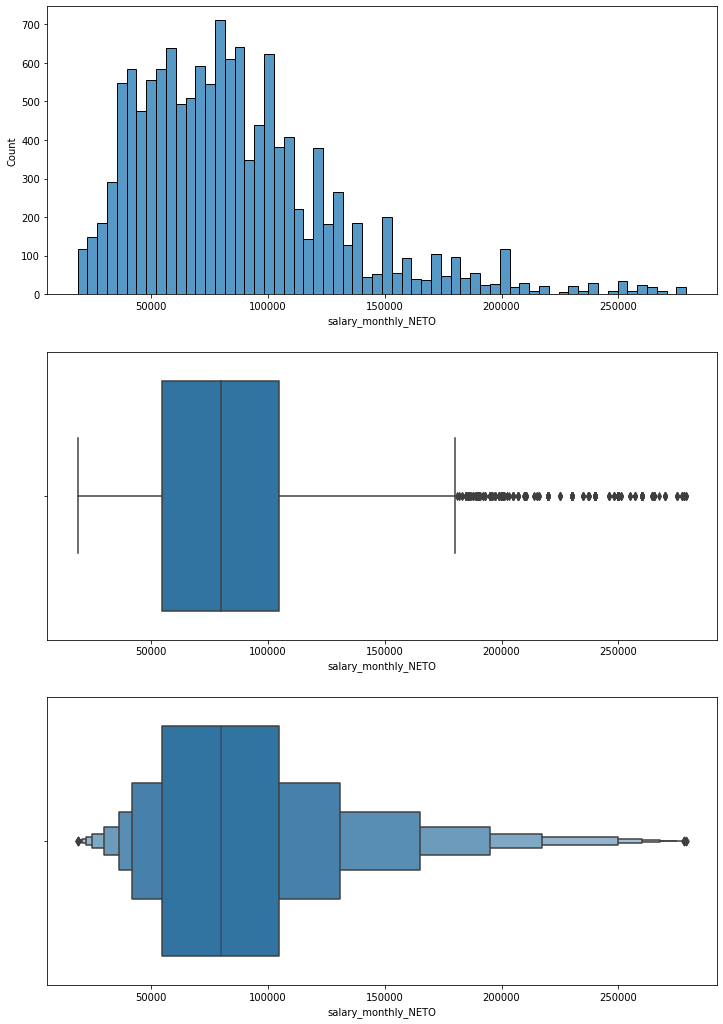

In [12]:
fig, axes = plt.subplots(figsize=(12, 18), nrows=3)
seaborn.histplot(x=df_filtered['salary_monthly_NETO'], ax=axes[0])
seaborn.boxplot(x=df_filtered['salary_monthly_NETO'], ax=axes[1])
seaborn.boxenplot(x=df_filtered['salary_monthly_NETO'], ax=axes[2])

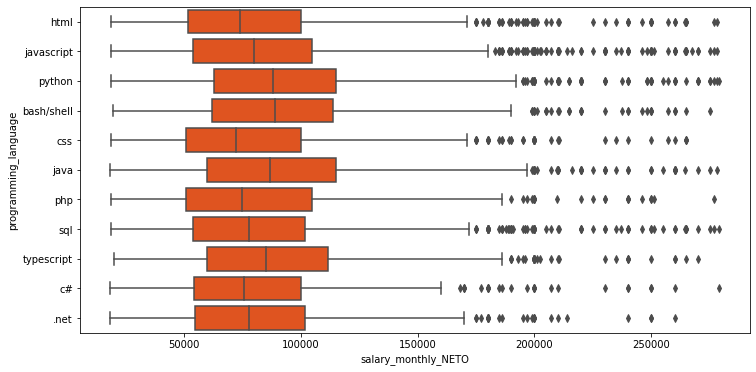

In [13]:
plt.figure(figsize=(12, 6))
seaborn.boxplot(data=df_filtered, x='salary_monthly_NETO', y='programming_language',
                color='orangered')
plt.ticklabel_format(style='plain', axis='x')

Por conocimeinto de campo, html y css suelen estar juntos - es muy raro tocar solo html o solo css, y la distribucion de ambas es muy parecida. Busco

In [14]:
html_css_filter_list=["html", "css", "HTML", "CSS", "Html", "Css"]
cured_test=["html", "javascript", "python", "php"]
# funcion que, dado un array original y un array de filtrado, devuelve el array nuevo, 
# eliminando los elementos que estan incluidos en el array de filtrado
#para cured_programming_languages --> array

def cured_lang_html_css( array_lang, list_filters):
  if any (x in array_lang for x in list_filters):
    filtered_array = [x for x in array_lang if x not in list_filters]
    filtered_array.append("html/css")
    array_lang=filtered_array
  return array_lang

cured_lang_html_css(cured_test, html_css_filter_list)

['javascript', 'python', 'php', 'html/css']

In [15]:
# funcion que, dado un string y un array, devuelve el string filtrado, 
# eliminando los elementos que estan incluidos en el array

# para tools_programming_languages --> string
def filtered_lang_html_or_css(string_of_lang, list_filters):
  if any (x in string_of_lang for x in list_filters):
    array_of_lang_from_string = [x.strip() for x in string_of_lang.split(",")]
    filtered_array_from_array_of_lang = [x for x in array_of_lang_from_string if x not in list_filters]
    string_of_lang=' '.join(filtered_array_from_array_of_lang)+" HTML/CSS"

  return string_of_lang

# test filtered_lang_html_or_css(example_lang_test, html_css_filter_list)

In [16]:
#filtramos valores nullos and so on
df_filter_of_null_values= (df.salary_monthly_NETO.isnull() == False)
df_filter_quantile= (df.salary_monthly_NETO > df.salary_monthly_NETO.quantile(0.04)) & (df.salary_monthly_NETO < df.salary_monthly_NETO.quantile(0.96))
df= df[ (df_filter_of_null_values) & (df_filter_quantile) ]

In [17]:
df["tools_programming_languages"]=[filtered_lang_html_or_css(str(x),html_css_filter_list) for x in df["tools_programming_languages"]]

In [18]:
df["cured_programming_languages"]=[cured_lang_html_css(x,html_css_filter_list) for x in df["cured_programming_languages"]]
#df["cured_programming_languages"]=[cured_lang_html_css(x,html_css_filter_list) for x in df["cured_programming_languages"]]


In [19]:
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
df_lang[:5]

,programming_language,tools_programming_languages,salary_monthly_NETO,profile_gender,cured_programming_languages
0,ninguno,Ninguno,43000.0,Mujer,[ninguno]
1,javascript,Javascript Python HTML/CSS,63000.0,Hombre,"[javascript, python, html/css]"
1,python,Javascript Python HTML/CSS,63000.0,Hombre,"[javascript, python, html/css]"
1,html/css,Javascript Python HTML/CSS,63000.0,Hombre,"[javascript, python, html/css]"
2,ninguno,Ninguno,127000.0,Mujer,[ninguno]


In [20]:
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
language_count[:10]

,language,frequency
0,javascript,2185
1,sql,1932
2,html/css,1698
3,java,1309
4,python,1294
5,bash/shell,896
6,php,786
7,.net,732
8,typescript,672
9,c#,651


In [21]:
interesting_languages = ["python", "javascript", "sql", "html/css","java", "bash/shell", "php", ".net", "typescript", "c#"]
filtered_df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]
filter_of_null_values= (filtered_df_lang.salary_monthly_NETO.isnull() == False)
filter_quantile= (filtered_df_lang.salary_monthly_NETO > filtered_df_lang.salary_monthly_NETO.quantile(0.04))
df_filtered = filtered_df_lang[ (filter_of_null_values) & (filter_quantile) ]

len(filtered_df_lang), len(df_filtered)

(12155, 11668)

In [22]:
df_filtered['salary_monthly_NETO'].describe().round()

count     11668.0
mean      88454.0
std       40477.0
min       32071.0
25%       58000.0
50%       81000.0
75%      107500.0
max      250000.0
Name: salary_monthly_NETO, dtype: float64

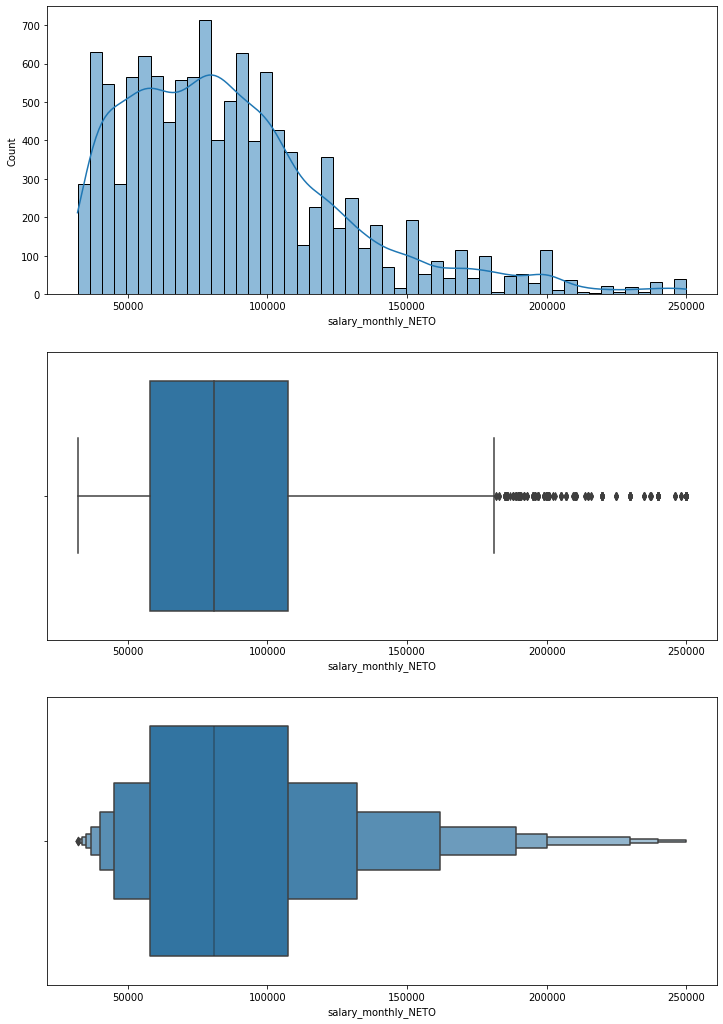

In [23]:
fig, axes = plt.subplots(figsize=(12, 18), nrows=3)
seaborn.histplot(x=df_filtered['salary_monthly_NETO'], ax=axes[0],kde=True)
seaborn.boxplot(x=df_filtered['salary_monthly_NETO'], ax=axes[1])
seaborn.boxenplot(x=df_filtered['salary_monthly_NETO'], ax=axes[2])

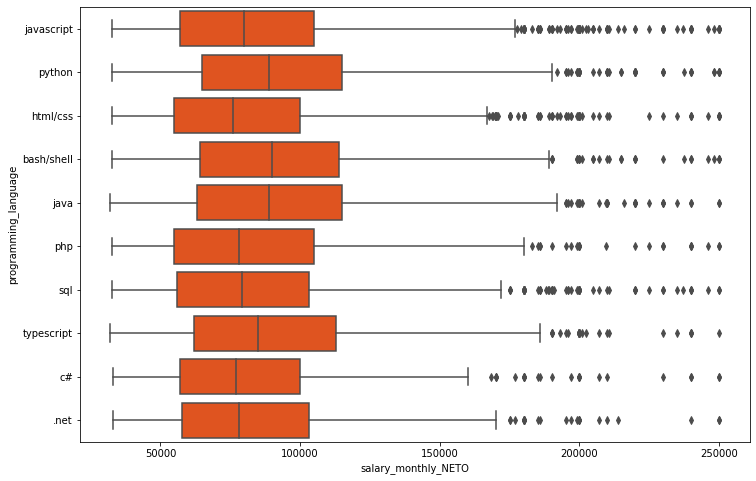

In [24]:
fig, axes = plt.subplots(figsize=(12, 8))

seaborn.boxplot(data=df_filtered, x='salary_monthly_NETO', y='programming_language',
                color='orangered')
plt.ticklabel_format(style='plain', axis='x')


In [25]:
'''
fig, axes = plt.subplots(figsize=(16, 10))
seaborn.histplot(x=df_filtered['salary_monthly_NETO'], y=df_filtered["programming_language"],cbar=True, cbar_kws=dict(shrink=.75))
#seaborn.heatmap(data=df_filtered["programming_language"], annot=True, fmt="d",)
'''

'\nfig, axes = plt.subplots(figsize=(16, 10))\nseaborn.histplot(x=df_filtered[\'salary_monthly_NETO\'], y=df_filtered["programming_language"],cbar=True, cbar_kws=dict(shrink=.75))\n#seaborn.heatmap(data=df_filtered["programming_language"], annot=True, fmt="d",)\n'

In [26]:


def get_sub_df_for_lang(lang):
  return df_filtered[ df_filtered["programming_language"]== lang]

temp_list_lang = []
for lang in interesting_languages:
  temp_list_lang.append((lang,get_sub_df_for_lang(lang)))

#get_sub_df_for_lang('java').describe()
"""
java_cols=get_sub_df_for_lang('java')
js_cols=get_sub_df_for_lang('javascript')
python_cols=get_sub_df_for_lang('python') 
html_css_cols=get_sub_df_for_lang('html/css')
bash_cols=get_sub_df_for_lang('bash/shell')
php_cols=get_sub_df_for_lang('php') 
sql_cols=get_sub_df_for_lang('sql')
ts_cols=get_sub_df_for_lang('typescript')
c_sharp_cols=get_sub_df_for_lang('c#') 
dot_net_cols=get_sub_df_for_lang('.net') 
"""
#java_cols.salary_monthly_NETO
#seaborn.histplot(x=df_filtered[ x== "javascript" for x in df["programming_language"]], ax=axes[0,0],kde=True)


"\njava_cols=get_sub_df_for_lang('java')\njs_cols=get_sub_df_for_lang('javascript')\npython_cols=get_sub_df_for_lang('python') \nhtml_css_cols=get_sub_df_for_lang('html/css')\nbash_cols=get_sub_df_for_lang('bash/shell')\nphp_cols=get_sub_df_for_lang('php') \nsql_cols=get_sub_df_for_lang('sql')\nts_cols=get_sub_df_for_lang('typescript')\nc_sharp_cols=get_sub_df_for_lang('c#') \ndot_net_cols=get_sub_df_for_lang('.net') \n"

In [27]:
colors = ["gold","orange","purple","forestgreen","blue","gray","magenta","saddlebrown","olive","black"]

In [28]:
#temp_list_lang[9][1]['salary_monthly_NETO'].median()
#temp_list_lang[0][1][temp_list_lang[0][1]['profile_gender']== "Hombre"]
for lang in temp_list_lang:
  print(lang[0])

python
javascript
sql
html/css
java
bash/shell
php
.net
typescript
c#


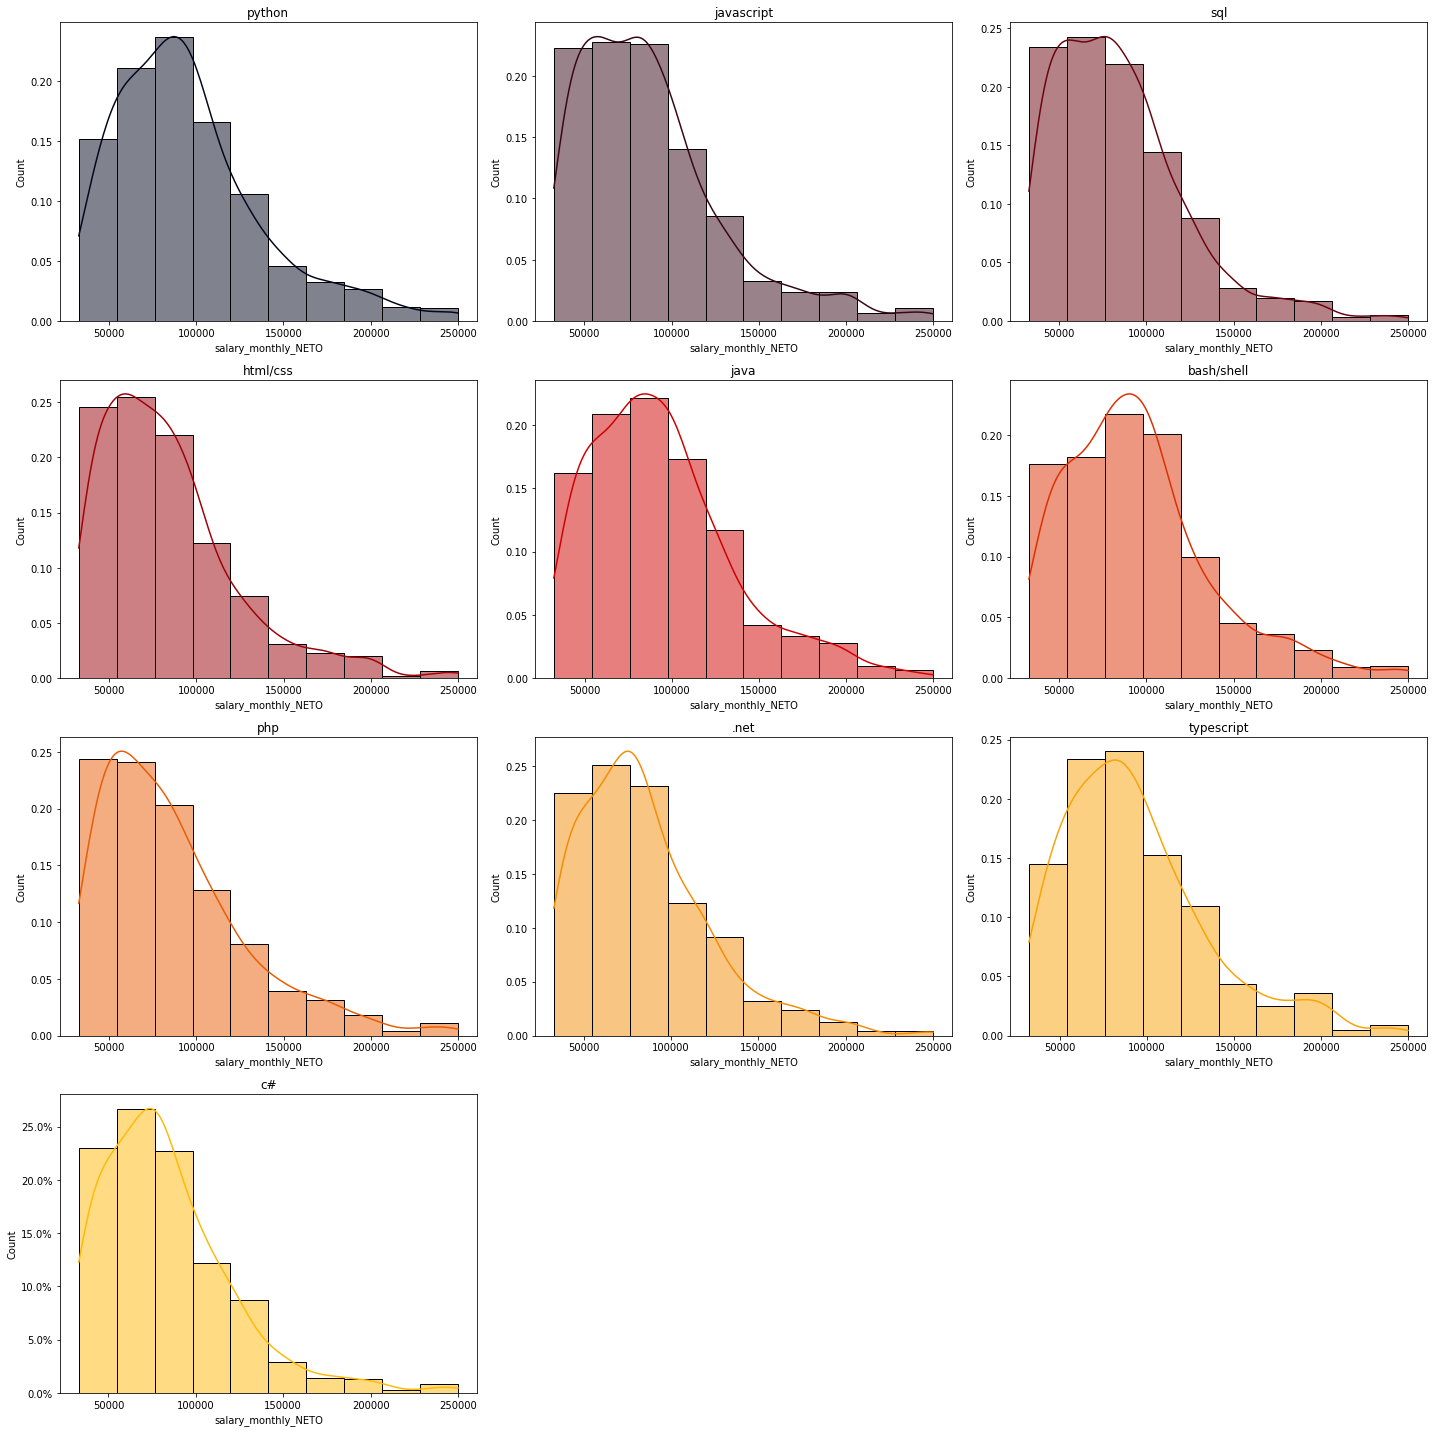

In [29]:
fig, axes = plt.subplots(figsize=(20, 20), nrows=4, ncols=3,)
colors_test=['#03071eff','#370617ff', '#6a040fff', '#9d0208ff','#d00000ff','#dc2f02ff','#e85d04ff','#f48c06ff','#faa307ff','#ffba08ff']
colors_test2=['#f72585ff','#b5179eff','#7209b7ff','#560badff','#480ca8ff','#3a0ca3ff','#3f37c9ff','#4361eeff','#4895efff','#4cc9f0ff']
k=0
for i in range(4):
  for j in range(3):
      #print(k)
      if k>=10: 
        break
      axes[i,j].title.set_text(temp_list_lang[k][0])
      seaborn.histplot(
          data=temp_list_lang[k][1],
          x=temp_list_lang[k][1]['salary_monthly_NETO'], 
          ax=axes[i,j],color=colors_test[k], 
          kde=True, 
          weights=numpy.ones(len(temp_list_lang[k][1])) / len(temp_list_lang[k][1]),
          bins=10,
          )
      k+=1

""" el codigo de arriba genera algo como esto
seaborn.histplot(x=java_cols['salary_monthly_NETO'], ax=axes[0,0],kde=True, label="Java")
seaborn.histplot(x=js_cols['salary_monthly_NETO'], ax=axes[0,1],kde=True, color="gold", label="JavaScript")
seaborn.histplot(x=python_cols['salary_monthly_NETO'], ax=axes[0,2],kde=True, color="orange", label="Python")
seaborn.histplot(x=html_css_cols['salary_monthly_NETO'], ax=axes[1,0],kde=True, color="purple", label="HTML/CSS")
seaborn.histplot(x=bash_cols['salary_monthly_NETO'], ax=axes[1,1],kde=True,  color="forestgreen",label="Bash")
seaborn.histplot(x=php_cols['salary_monthly_NETO'], ax=axes[1,2],kde=True,color="darkslateblue", label="PHP")
seaborn.histplot(x=sql_cols['salary_monthly_NETO'], ax=axes[2,0],kde=True, color="gray",label="SQL")
seaborn.histplot(x=ts_cols['salary_monthly_NETO'], ax=axes[2,1],kde=True, color="magenta",label="TypeScript")
seaborn.histplot(x=c_sharp_cols['salary_monthly_NETO'], ax=axes[2,2],kde=True,color="saddlebrown", label="C#")
seaborn.histplot(x=dot_net_cols['salary_monthly_NETO'], ax=axes[3,0],kde=True, color="olive",label=".NET")
"""
fig.tight_layout()
fig.delaxes(axes[3, 1])
fig.delaxes(axes[3, 2])
plt.ticklabel_format(style='plain', axis='x')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#en vez de count usar la frecuencia relativa para comparar mejor segun el total de la poblacion

In [30]:
print('Mediana por lenguaje')
medianas_por_lenguaje=[]
#for lang in interesting_languages:
#  temp_list_lang.append([lang,get_sub_df_for_lang(lang)])

for lang in temp_list_lang:
  medianas_por_lenguaje.append([lang[0],
                                lang[1]['salary_monthly_NETO'].median(),
                                lang[1][lang[1]['profile_gender']== "Hombre"]['salary_monthly_NETO'].median(),
                                lang[1][lang[1]['profile_gender']== "Mujer"]['salary_monthly_NETO'].median(),
                               ])
  #medianas_por_leguaje[i][0]=temp_list_lang[i][0] 
  #medianas_por_leguaje[i][1]=temp_list_lang[i][1]['salary_monthly_NETO'].median() 

print(medianas_por_lenguaje)

Mediana por lenguaje
[['python', 89000.0, 90000.0, 75000.0], ['javascript', 80000.0, 82000.0, 68000.0], ['sql', 79000.0, 80000.0, 68450.0], ['html/css', 75998.0, 78000.0, 64850.0], ['java', 88900.0, 90000.0, 71480.0], ['bash/shell', 90000.0, 90000.0, 69602.0], ['php', 78000.0, 80000.0, 63276.0], ['.net', 78200.0, 80000.0, 68450.0], ['typescript', 85000.0, 87000.0, 72516.5], ['c#', 77050.0, 78000.0, 68000.0]]


In [31]:
#print('Mediana por genero por lenguaje')
#temp_list_lang[0][1][temp_list_lang[0][1]['profile_gender']== "Hombre"]['salary_monthly_NETO']
#temp_list_lang[0][1][temp_list_lang[0][1]['profile_gender']== "Mujer"]['salary_monthly_NETO'].median()
#(media_h - media_m)/media_h *100

"""
for i in range(10):
  mediana_h=temp_list_lang[i][1][temp_list_lang[i][1]['profile_gender']== "Hombre"]['salary_monthly_NETO'].median()
  mediana_m=temp_list_lang[i][1][temp_list_lang[i][1]['profile_gender']== "Mujer"]['salary_monthly_NETO'].median()
  #print( temp_list_lang[i][0], mediana_h, mediana_m)

  print( temp_list_lang[i][0], 
        '   mediana Hombre: ', 
        mediana_h, 
        '   mediana Hombre: ', 
        mediana_m,
        '   diferencia mediana Mujer: ', 
        (mediana_h-mediana_m)/mediana_h * 100
        )
"""

'\nfor i in range(10):\n  mediana_h=temp_list_lang[i][1][temp_list_lang[i][1][\'profile_gender\']== "Hombre"][\'salary_monthly_NETO\'].median()\n  mediana_m=temp_list_lang[i][1][temp_list_lang[i][1][\'profile_gender\']== "Mujer"][\'salary_monthly_NETO\'].median()\n  #print( temp_list_lang[i][0], mediana_h, mediana_m)\n\n  print( temp_list_lang[i][0], \n        \'   mediana Hombre: \', \n        mediana_h, \n        \'   mediana Hombre: \', \n        mediana_m,\n        \'   diferencia mediana Mujer: \', \n        (mediana_h-mediana_m)/mediana_h * 100\n        )\n'

In [32]:
df_lang_median_gender = pd.DataFrame(medianas_por_lenguaje, columns=['lenguaje', 'mediana_salario_neto_total','mediana_salario_neto__hombre','mediana_salario_neto__mujer'])
df_lang_median_gender

,lenguaje,mediana_salario_neto_total,mediana_salario_neto__hombre,mediana_salario_neto__mujer
0,python,89000.0,90000.0,75000.0
1,javascript,80000.0,82000.0,68000.0
2,sql,79000.0,80000.0,68450.0
3,html/css,75998.0,78000.0,64850.0
4,java,88900.0,90000.0,71480.0
5,bash/shell,90000.0,90000.0,69602.0
6,php,78000.0,80000.0,63276.0
7,.net,78200.0,80000.0,68450.0
8,typescript,85000.0,87000.0,72516.5
9,c#,77050.0,78000.0,68000.0


## Respuesta ejercicio 1

1 - ¿Cuáles son los lenguajes de programación asociados a los mejores salarios?

Seleccionar las columnas relevantes para analizar

columnas: `programming_language 	tools_programming_languages 	salary_monthly_NETO 	cured_programming_languages`

programming_language 	tools_programming_languages 	salary_monthly_NETO 	cured_programming_languages

In [33]:
#¿Cuáles son los lenguajes de programación asociados a los mejores salarios?

# Ejercicio 2 - Densidades y varias varialbes

Responder a la pregunta general: **¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?**

Para ello considere (igual al ejercicio Anterior):
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones. 

## a) Densidad conjunta

Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa




## b) Asociación

* Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría



## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación






## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)
